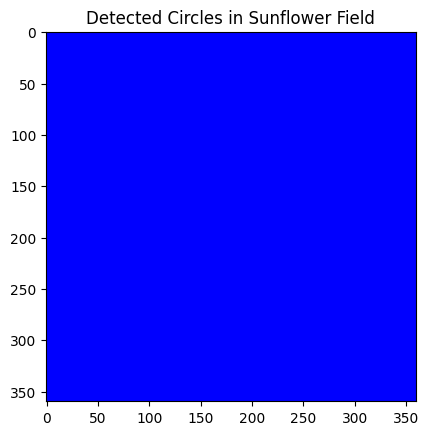

Detected 232788 circles with sigma values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Parameters
sigma_values = np.linspace(1, 10, 10)  # Define sigma range for different scales
threshold = 0.3  # Threshold for detection

# List to hold detected circles (x, y, radius)
circles = []

for sigma in sigma_values:
    # Apply GaussianBlur and Laplacian
    blurred = cv.GaussianBlur(gray_image, (0, 0), sigma)
    log_image = cv.Laplacian(blurred, cv.CV_64F)
    
    # Find local maxima
    maxima = (log_image == cv.dilate(log_image, None))
    thresholded = (log_image > threshold) & maxima
    
    # Extract circle centers and radius
    yx = np.argwhere(thresholded)
    for y, x in yx:
        circles.append((x, y, sigma * np.sqrt(2)))  # sigma*sqrt(2) approximates the blob radius

# Draw circles on the image
for (x, y, radius) in circles:
    cv.circle(image, (int(x), int(y)), int(radius), (255, 0, 0), 2)

# Show the result
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title("Detected Circles in Sunflower Field")
plt.show()

# Print parameters
print(f"Detected {len(circles)} circles with sigma values: {sigma_values}")


Best-fit line parameters: a=0.75, b=-0.66, d=1.43


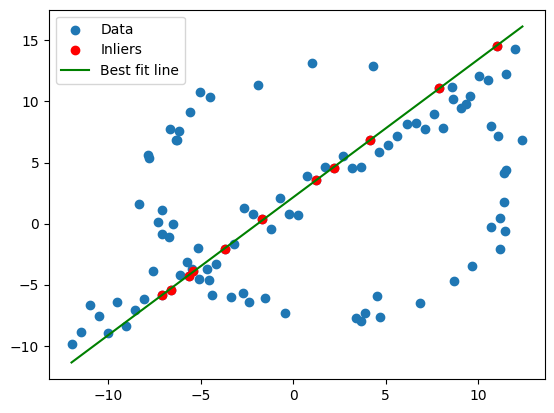

In [3]:
# Generate synthetic data
np.random.seed(0)
N = 100
r, x0_gt, y0_gt = 10, 2, 3  # True circle parameters
s = r / 16  # Circle noise level
t = np.random.uniform(0, 2 * np.pi, N // 2)
x, y = x0_gt + (r + s * np.random.randn(N // 2)) * np.cos(t), y0_gt + (r + s * np.random.randn(N // 2)) * np.sin(t)
X_circle = np.vstack((x, y)).T

m, b = 1, 2  # True line parameters
x = np.linspace(-12, 12, N // 2)
y = m * x + b + np.random.randn(N // 2)
X_line = np.vstack((x, y)).T
X = np.vstack((X_circle, X_line))  # Combine data

# RANSAC for Line Fitting
def fit_line_ransac(X, num_samples=2, num_iterations=100, threshold=0.1):
    best_inliers = []
    for _ in range(num_iterations):
        # Randomly sample points
        idx = np.random.choice(X.shape[0], num_samples, replace=False)
        sample = X[idx]
        
        # Fit line to sample
        p1, p2 = sample
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        d = p1[1] * p2[0] - p1[0] * p2[1]
        norm = np.sqrt(a**2 + b**2)
        a, b, d = a / norm, b / norm, d / norm
        
        # Find inliers
        distances = np.abs(X @ np.array([a, b]) + d)  # Normal distance
        inliers = X[distances < threshold]
        
        # Update best inliers
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_params = (a, b, d)
            
    return best_params, best_inliers

params, inliers = fit_line_ransac(X)
a, b, d = params
print(f"Best-fit line parameters: a={a:.2f}, b={b:.2f}, d={d:.2f}")

# Plot the result
plt.scatter(X[:, 0], X[:, 1], label='Data')
plt.scatter(inliers[:, 0], inliers[:, 1], label='Inliers', color='r')
x_vals = np.array([np.min(X[:, 0]), np.max(X[:, 0])])
y_vals = -(a / b) * x_vals - d / b
plt.plot(x_vals, y_vals, label='Best fit line', color='g')
plt.legend()
plt.show()


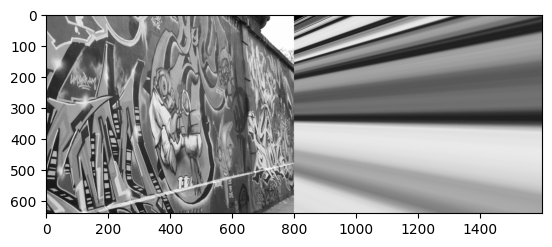

In [5]:
# Load images
img1 = cv.imread('Images/graf/img1.ppm', cv.IMREAD_GRAYSCALE)
img5 = cv.imread('Images/graf/img5.ppm', cv.IMREAD_GRAYSCALE)

# Detect SIFT features and match
sift = cv.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img5, None)

# Match features using FLANN-based matcher
matcher = cv.FlannBasedMatcher()
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Filter matches using Lowe's ratio test
good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]

# Extract matched keypoints for homography
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

# Compute homography with RANSAC
H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

# Stitch images together
stitched = cv.warpPerspective(img1, H, (img5.shape[1] + img1.shape[1], img5.shape[0]))
stitched[0:img5.shape[0], 0:img5.shape[1]] = img5

# Show result
plt.imshow(stitched, cmap='gray')
plt.show()
